In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)
hide_toggle()

### Add 'hide_toggle()' in the cell to collapse

## Import Libraries

In [2]:
import numpy as np
import os, requests
from matplotlib import pyplot as plt
hide_toggle()

## Import plot functions and define parameters

In [3]:
# import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True
hide_toggle()

## Load data

In [4]:
# Load Data
fname = []
for j in range(3):
    fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
    if not os.path.isfile(fname[j]):
        try:
            r = requests.get(url[j])
        except requests.ConnectionError:
            print("!!! Failed to download data !!!")
        else:        
            if r.status_code != requests.codes.ok:
                print("!!! Failed to download data !!!")
            else:
                with open(fname[j], "wb") as fid:
                    fid.write(r.content)
hide_toggle()

In [5]:
# Data loading
alldat = np.array([])
for j in range(len(fname)):
    alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat = alldat[11]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'lfp', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'waveform_w', 'waveform_u', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'lfp_passive', 'pupil_passive', 'wheel_passive'])


In [6]:
dat['pupil'].shape #  (3, 340, 250) <-- (pupil area, pupil horizontal, pupil vertical), 250 time bins, 340 trials
len(dat['pupil'])
pupil_area = dat['pupil'][1,:,:]
# pupil_area.shape
len(pupil_area)

340

## Group brain regions

In [7]:
# groupings of brain regions
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 4 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
    barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region

#plots by brain region and response
#or j in range(nareas):
    


## Plot: mean neural activity vs response

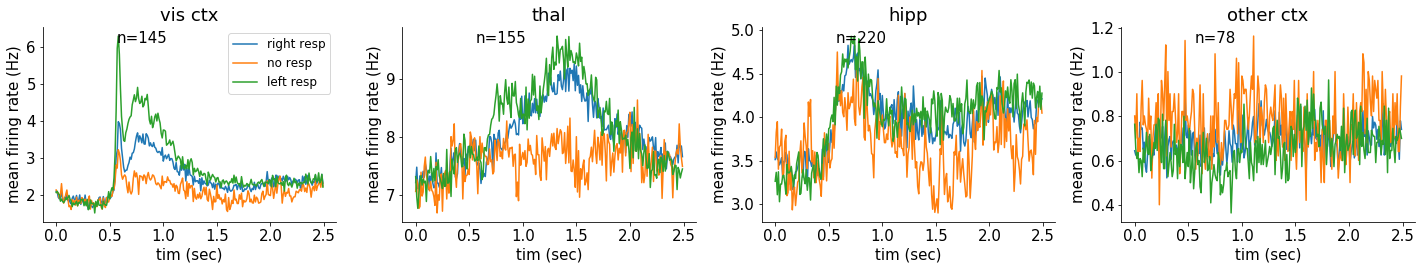

In [8]:
# plots by brain region and responses
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

response = dat['response'] # right - nogo - left (-1, 0, 1)

for j in range(nareas):
    ax = plt.subplot(1,nareas,j+1)
  
    plt.plot(dt * np.arange(NT), 1/dt *  dat['spks'][barea==j][:,response>=0].mean(axis=(0,1)))
    plt.plot(dt * np.arange(NT), 1/dt *  dat['spks'][barea==j][:,response==0].mean(axis=(0,1)))
    plt.plot(dt * np.arange(NT), 1/dt *  dat['spks'][barea==j][:,response<0].mean(axis=(0,1)))  
    plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)

    if j==0:
        plt.legend(['right resp','no resp', 'left resp'], fontsize=12)
    ax.set(xlabel = 'tim (sec)', ylabel = 'mean firing rate (Hz)', title = regions[j])
hide_toggle()

### PCA (run the cells in the next ' Test PCA' section first)

In [9]:
#title top PC directions from stimulus + response period, with projections of the entire duration
from sklearn.decomposition import PCA

droll = np.reshape(dat['spks'][:,:,51:130], (NN,-1)) # first 80 bins = 1.6 sec
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components = 5).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'], (NN,-1))
pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

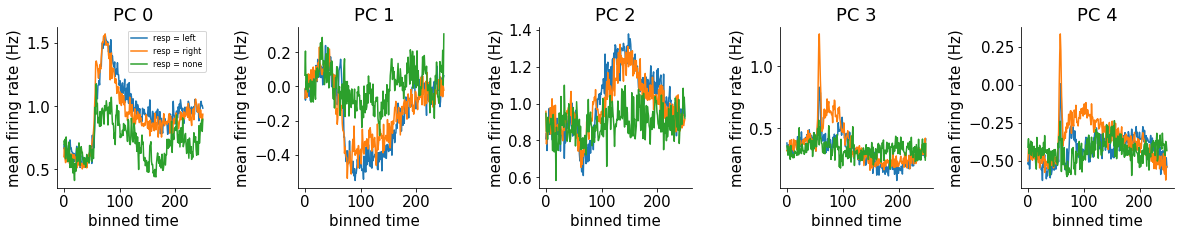

In [10]:
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
    pc1 = pc_10ms[j]
    ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)

    plt.plot(pc1[response>0, :].mean(axis=0))
    plt.plot(pc1[response<0, :].mean(axis=0))
    plt.plot(pc1[response==0, :].mean(axis=0))

    if j==0:
        plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
    ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
    plt.title('PC %d'%j)

In [11]:
pc1.shape

(340, 250)

In [12]:
pc1[response>0,:].shape

(135, 250)

## Plot: mean neural activity vs task difficulty

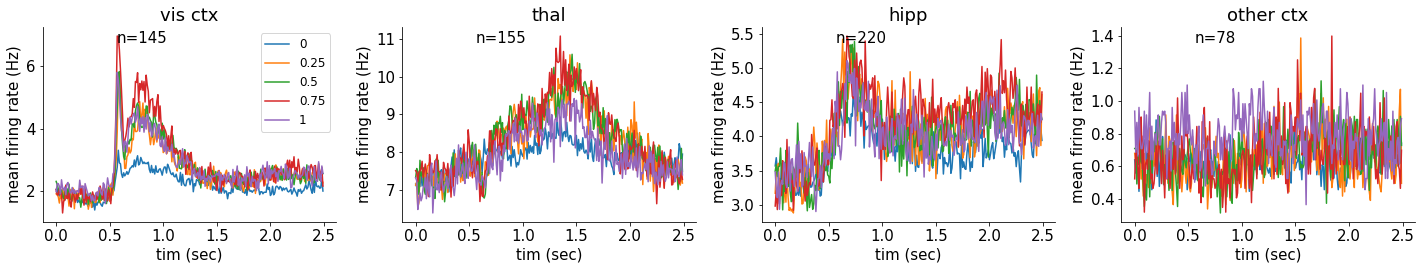

In [13]:
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

l_cont = dat['contrast_left']
r_cont = dat['contrast_right']

for j in range(nareas):
    ax = plt.subplot(1,nareas,j+1)
    
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0][barea==j].mean(axis=(0,1))) # difference 0
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.25][barea==j].mean(axis=(0,1))) # difference 0.25
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.5][barea==j].mean(axis=(0,1))) # difference 0.5
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==0.75][barea==j].mean(axis=(0,1))) # difference 0.75
    plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,np.abs(l_cont-r_cont)==1][barea==j].mean(axis=(0,1))) # difference 1
  
    plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)

    if j==0:
        plt.legend(['0', '0.25', '0.5', '0.75', '1'], fontsize=12)
    ax.set(xlabel = 'tim (sec)', ylabel = 'mean firing rate (Hz)', title = regions[j])
hide_toggle()

### PCA

In [14]:
l_cont.shape

(340,)

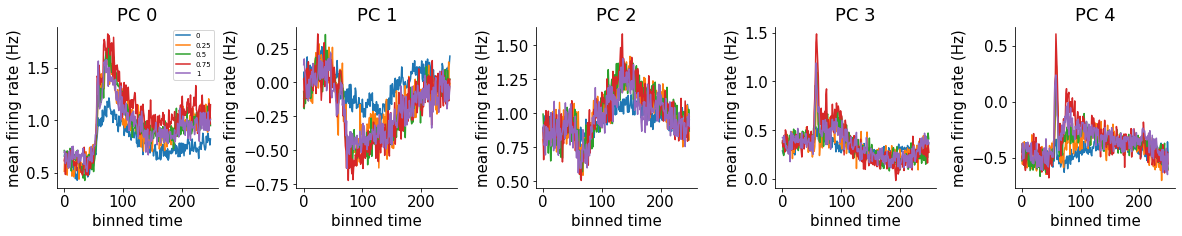

In [15]:
plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
    pc1 = pc_10ms[j]
    ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)

    plt.plot(pc1[np.abs(l_cont-r_cont)==0,:].mean(axis=0))
    plt.plot(pc1[np.abs(l_cont-r_cont)==0.25,:].mean(axis=0))  
    plt.plot(pc1[np.abs(l_cont-r_cont)==0.5,:].mean(axis=0))  
    plt.plot(pc1[np.abs(l_cont-r_cont)==0.75,:].mean(axis=0))  
    plt.plot(pc1[np.abs(l_cont-r_cont)==1,:].mean(axis=0))  

    if j==0:
        plt.legend(['0', '0.25', '0.5', '0.75', '1'], fontsize=7)
    ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
    plt.title('PC %d'%j)
hide_toggle()    

## PCA of hippocampus only (test)

brain area:  hipp
diff_cont:  0.75
NNhp =  220
dr.shape:  (220, 11000)
mdl.components_.shape:  (5, 220)
pc_hp.shape: (5, 85000)
after reshaping pc_hp.shape: (5, 340, 250)


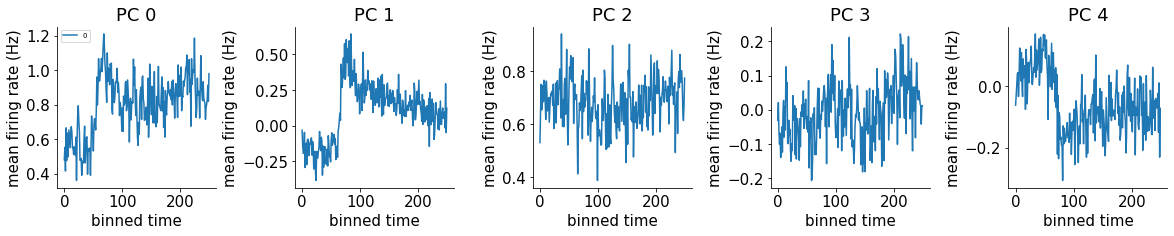

In [16]:
# brain area: 
# [visual cortex, thalamus, hippocampal, non-visual cortex, other(midbrain, basal ganglia, cortical subplate)] = [0,1,2,3,4]
j_barea = 2

# contrast difference: 
diff_cont = [0, 0.25, 0.5, 0.75 ,1]
i=3

plt.figure(figsize= (20, 6))
# =============================================================================================
NNhp = len(dat['spks'][barea==j_barea][:,np.abs(l_cont-r_cont)==diff_cont[i]]) # shape: 220, 126, 250
print('brain area: ', regions[j_barea])
print('diff_cont: ', diff_cont[i])
print('NNhp = ', NNhp) # NNhp is indep of the diff_cont. but depends on the brain area.

# original shape (contrast diff 0): (220, 126, 250)
dr = np.reshape(dat['spks'][barea==j_barea][:,np.abs(l_cont-r_cont)==diff_cont[i]], (NNhp,-1)) 
dr = dr - np.mean(dr, axis=1)[:,np.newaxis]
print('dr.shape: ', dr.shape) # dr depends on both the brain area and diff_cont.

mdl = PCA(n_components = 5).fit(dr.T)
print('mdl.components_.shape: ', mdl.components_.shape)
W = mdl.components_
pc_hp = W @ np.reshape(dat['spks'][barea==j_barea], (NNhp,-1))
print('pc_hp.shape:',pc_hp.shape)
pc_hp = np.reshape(pc_hp, (5,-1,NT))
print('after reshaping pc_hp.shape:',pc_hp.shape)
# pchp_1 = pc_hp[1]

#     plt.plot(pchp_1[np.logical_and(np.abs(l_cont-r_cont)==0), :].mean(axis=0))  
for j in range(len(pc_hp)):
    pchp1 = pc_hp[j]
    ax = plt.subplot(2,len(pc_hp)+1,len(pc_hp)+1 + j+1)

    plt.plot(pchp1[np.abs(l_cont-r_cont)==diff_cont[i],:].mean(axis=0))
#     plt.plot(pchp1[np.abs(l_cont-r_cont)==0.25,:].mean(axis=0))  
#     plt.plot(pchp1[np.abs(l_cont-r_cont)==0.5,:].mean(axis=0))  
#     plt.plot(pchp1[np.abs(l_cont-r_cont)==0.75,:].mean(axis=0))  
#     plt.plot(pchp1[np.abs(l_cont-r_cont)==1,:].mean(axis=0))  
    if j==0:
        plt.legend(['0', '0.25', '0.5', '0.75', '1'], fontsize=7)

    ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
    plt.title('PC %d'%j)

hide_toggle()

## PCA test: 5 PCs of neural activityfor different task difficulties

Define brain area:

[visual cortex, thalamus, hippocampal, non-visual cortex, other(midbrain, basal ganglia, cortical subplate)] = [0,1,2,3,4]

In [17]:
j_barea = 2

Define the contrast difference

In [18]:
diff_cont = [0, 0.25, 0.5, 0.75 ,1]

Define a function to compute PC for a given brain area and the contrast difference

In [19]:
NNhp

220

### Functions for PCA & plots

In [20]:
def compute_pc(j_barea, idx_contrast):
    i = idx_contrast
    
    # shape: (220, 126, 250) <-- this and NNhp dep. on b_area/difficulty
    NNhp = len(dat['spks'][barea==j_barea][:,np.abs(l_cont-r_cont)==diff_cont[i]]) 
    print('brain area: ', regions[j_barea])
    print('diff_cont: ', diff_cont[i])
    print('NNhp = ', NNhp) # NNhp is indep of the diff_cont. but depends on the brain area.

    # original shape (contrast diff 0): (220, 126, 250)gg
    dr = np.reshape(dat['spks'][barea==j_barea][:,np.abs(l_cont-r_cont)==diff_cont[i]], (NNhp,-1)) 
    dr = dr - np.mean(dr, axis=1)[:,np.newaxis]
    print('dr.shape: ', dr.shape) # dr depends on both the brain area and diff_cont.

    mdl = PCA(n_components = 5).fit(dr.T)
    W = mdl.components_
    pc_hp = W @ np.reshape(dat['spks'][barea==j_barea], (NNhp,-1))
    print('pc_hp.shape ', pc_hp.shape)
    pc_hp = np.reshape(pc_hp, (5,-1,NT))
    return pc_hp

In [21]:
def compute_pc_np(j_barea, idx_contrast): # same as 'compute_pc' but without printing out anything
    i = idx_contrast
    
    NNhp = len(dat['spks'][barea==j_barea][:,np.abs(l_cont-r_cont)==diff_cont[i]])

    dr = np.reshape(dat['spks'][barea==j_barea][:,np.abs(l_cont-r_cont)==diff_cont[i]], (NNhp,-1)) 
    dr = dr - np.mean(dr, axis=1)[:,np.newaxis]
    
    mdl = PCA(n_components = 5).fit(dr.T)
    W = mdl.components_
    pc_hp = W @ np.reshape(dat['spks'][barea==j_barea], (NNhp,-1))
#     print('pc_hp.shape ', pc_hp.shape)
    pc_hp = np.reshape(pc_hp, (5,-1,NT))
    return pc_hp, NNhp

In [22]:
def plot_pca(pc_hp):
    """
    make sure to have 'plt.figure(figsize= (20, 6))' before this function.
    
    """
    for j in range(len(pc_hp)):
        pchp1 = pc_hp[j]
#         ax = plt.subplot(2,len(pc_hp)+1,len(pc_hp)+1 + j+1)

        axs[j].plot(pchp1[np.abs(l_cont-r_cont)==diff_cont[idx_contrast],:].mean(axis=0))
        if j==0:
            axs[j].legend(['0', '0.25', '0.5', '0.75', '1'], fontsize=9)

#         ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
#         axs[i].set_title('PC %d'%j)

## This one works ↓

NN:  220
NN:  220
NN:  220
NN:  220
NN:  220


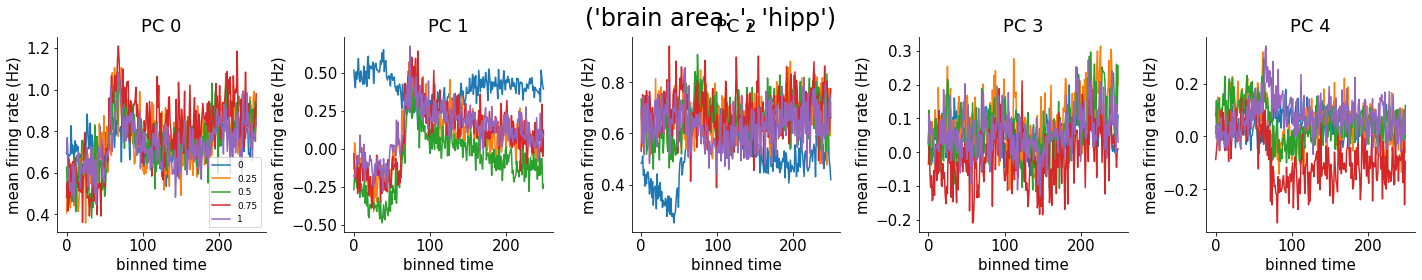

In [23]:
fig, axs = plt.subplots(1,5)
j_barea = 2
# 'brain area: ', regions[j_barea]

fig.suptitle(('brain area: ',regions[j_barea]), fontsize=24)
    
for ax in axs.flat:
    ax.set(xlabel='binned time', ylabel='mean firing rate (Hz)')

for idx_contrast in range(len(diff_cont)):
    axs[idx_contrast].set_title('PC %d'%idx_contrast)
    
    pc_hp, NNhp = compute_pc_np(j_barea, idx_contrast)
    print('NN: ',NNhp)
#     print('--------------------')
    plot_pca(pc_hp)

# plt.tight_layout()
hide_toggle()

------------------------------------------------------------------------------------------------------------

In [24]:
# reshape the spiking data from (neurons, trials, time bins) to (neurons, trials) <-- reduce time bins?
np.reshape(dat['spks'][:,:,51:130], (NN,-1)).shape # shape = (698, 340, 79)

(698, 26860)

In [25]:
#droll previously defined - change if necessary
#droll = np.reshape(dat['spks'][:,:,51:130], (NN,-1)) # first 80 bins = 1.6 sec
#droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
#model = PCA(n_components = 5).fit(droll.T)
#W = model.components_
#pc_10ms = W @ np.reshape(dat['spks'], (NN,-1))
#pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

In [26]:
#dat['spks'].shape[-1]

In [27]:
def pca_taskdiff(idx_brain_area, contrast_difference):
    
    """
    Take the index of the brain area and the contrast difference, returns pca
    """
#     NT = dat['spks'].shape[-1]
    j_barea = idx_brain_area
    
    NN_area = len(dat['spks'][barea==j_barea][:,np.abs(l_cont-r_cont)==contrast_difference]) # shape: 220, 126, 250
    dr = np.reshape(dat['spks'][barea==j_barea][:,np.abs(l_cont-r_cont)==diff_cont[i]], (NN_area,-1)) 
    dr = dr - np.mean(dr, axis=1)[:,np.newaxis]
    mdl = PCA(n_components = 5).fit(dr.T)
    W = mdl.components_
    pc_area = W @ np.reshape(dat['spks'][barea==j_barea], (NN_area,-1))
    pc_area = np.reshape(pc_area, (5,-1,NT))


    return pc_hp

## Test PCA (referenced from 'load_steinmetz_decisions.ipynb')
(https://github.com/NeuromatchAcademy/course-content/blob/master/projects/load_steinmetz_decisions.ipynb)

In [28]:
#droll previously defined - change if necessary
#droll = np.reshape(dat['spks'][:,:,51:130], (NN,-1)) # first 80 bins = 1.6 sec
#droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
#model = PCA(n_components = 5).fit(droll.T)
#W = model.components_
#pc_10ms = W @ np.reshape(dat['spks'], (NN,-1))
#pc_10ms = np.reshape(pc_10ms, (5, -1, NT))

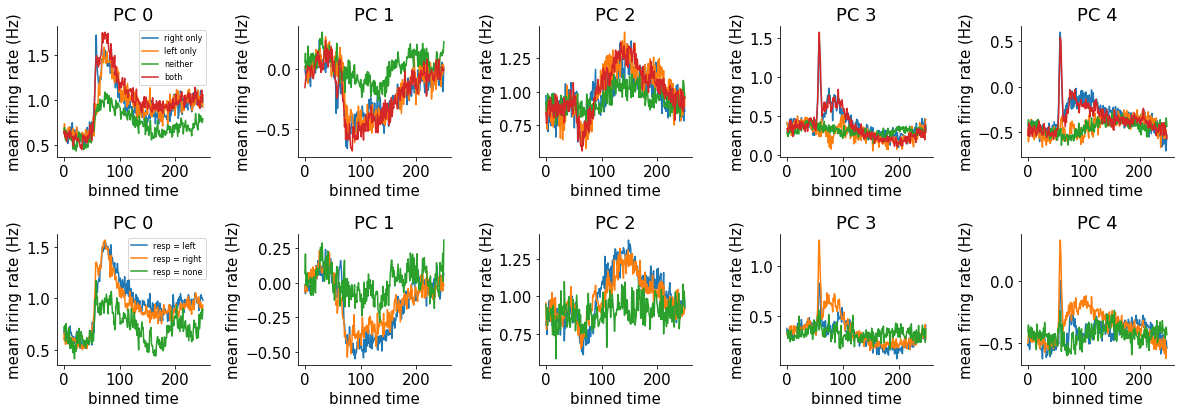

In [29]:
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left']   # 0 - low - high

plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
    ax = plt.subplot(2,len(pc_10ms)+1,j+1)
    pc1 = pc_10ms[j]

    plt.plot(pc1[np.logical_and(vis_left==0, vis_right>0), :].mean(axis=0))  
    plt.plot(pc1[np.logical_and(vis_left>0, vis_right==0), :].mean(axis=0))
    plt.plot(pc1[np.logical_and(vis_left==0, vis_right==0), :].mean(axis=0))
    plt.plot(pc1[np.logical_and(vis_left>0, vis_right>0), :].mean(axis=0))

    if j==0:
        plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
    ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
    plt.title('PC %d'%j)

    ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)

    plt.plot(pc1[response>0, :].mean(axis=0))
    plt.plot(pc1[response<0, :].mean(axis=0))
    plt.plot(pc1[response==0, :].mean(axis=0))

    if j==0:
        plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
    ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
    plt.title('PC %d'%j)

# Encoding - Modeling Neuronal Data

In [30]:
#define the variables
dat['pupil'].shape #  (3, 340, 250) <-- (pupil area, pupil horizontal, pupil vertical), 250 time bins, 340 trials
#len(dat['pupil'])
pupil_area = dat['pupil'][0,:,:]
pupil_area_T = np.transpose(pupil_area)
working_pupil_area = np.sum(pupil_area_T, axis=0)
working_pupil_area.shape

#plt.plot(pupil_area)
#plt.show()
reward = dat['feedback_type'] #reward history

current_trial = dat['contrast_left'] #current trial difficulty

choice = dat['response']#choice
#trial history difficulty

spikes = dat['spks'] #spikes / Neuronal data
pop_spikes = np.sum(spikes, axis = 0)
for i in pop_spikes:
    pop_spikes_T = np.transpose(pop_spikes)
    working_spikes = np.sum(pop_spikes_T[i], axis=0)
#working_spikes.shape
#plt.plot(working_spikes)
#plt.show()

print(f"Pupil Variable Shape: {working_pupil_area.shape}",
      f"Reward Variable Shape: {reward.shape}",
      f"Current Trial Contrast Variable Shape: {working_pupil_area.shape}",
      f"Neuronal Data Variable Shape: {working_spikes.shape}")

Pupil Variable Shape: (340,) Reward Variable Shape: (340,) Current Trial Contrast Variable Shape: (340,) Neuronal Data Variable Shape: (340,)


In [116]:
l_cont = dat['contrast_left']
r_cont = dat['contrast_right']

arr = np.array([l_cont,r_cont])
contrast = np.stack(arr)
contrast_difference = contrast[0,:]-contrast[1,:]

#print(contrast)
#(l_cont-r_cont)==0
#for i in contrast:
contrast_difference==0

array([ True,  True,  True, False, False,  True, False, False, False,
       False, False, False, False,  True,  True,  True, False, False,
       False, False, False, False,  True, False, False,  True, False,
       False,  True,  True, False,  True,  True,  True, False, False,
       False, False,  True, False, False,  True, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False,  True,  True, False,
       False,  True, False, False,  True,  True, False, False, False,
        True, False,  True, False,  True, False, False, False,  True,
       False,  True,  True, False, False,  True,  True, False, False,
       False,  True,  True,  True,  True,  True,  True, False, False,
        True, False, False, False, False, False,  True,  True, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True, False,  True,  True,
        True,  True,

In [137]:
current_trial_difficulty = []
for i in contrast_difference:
    if contrast_difference.any()==0: # difference 0
        [0 if contrast_difference==0 else i for i in current_trial_difficulty]    
    elif contrast_difference.any()==0.25: # difference 0.25
        current_trial_difficulty.append(0.25)
    elif contrast_difference.any()==0.5: # difference 0.5
        current_trial_difficulty.append(0.5)
    elif contrast_difference.any()==0.75: # difference 0.75
        current_trial_difficulty.append(0.75)
    elif contrast_difference.any()==1: # difference 1
        current_trial_difficulty.append(1)
    else:
        print(current_trial_difficulty)
#    return current_trial_difficulty
#print(current_trial_difficulty)
current_trial_difficulty

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
#https://realpython.com/linear-regression-in-python/
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

#setup_x 
X = np.array([working_pupil_area, reward, choice])
#X = np.hstack((working_pupil_area, reward))
#X = np.squeeze(X)
X = np.transpose(X)

#setup_y 
y = working_spikes
#y = np.transpose(y)

#print(X)

In [ ]:
#Transform X
transformer = PolynomialFeatures(degree=2, include_bias=False)
#Fit Transformer
transformer.fit(X)

X_ = transformer.transform(X) #Once transformer is fitted, it’s ready to create a new, modified input.

#Alternative one line of code for above 3 lines
#X_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X)
print(X_)


In [ ]:
#Model Fit
#model = LinearRegression().fit(X, y)
model = LinearRegression().fit(X_, y)


In [ ]:
model = LinearRegression().fit(X_, y)
r_sq = model.score(X_, y) #.score() returns 𝑅²
print('coefficient of determination:', r_sq) 
print('intercept:', model.intercept_)
print('slope:', model.coef_)
#The values of the weights are associated to .intercept_ and .coef_: .intercept_ represents 𝑏₀, while .coef_ references the array that contains 𝑏₁ and 𝑏₂ respectively.

In [ ]:
#X_ = PolynomialFeatures(degree=2, include_bias=True).fit_transform(x)

#If you call PolynomialFeatures with the default parameter include_bias=True (or if you just omit it), you’ll obtain the new input array x_ with the additional leftmost column containing only ones.

In [ ]:
#Predict the response
#y_pred = model.predict(X)
#print('predicted response:', y_pred, sep='\n')

y_pred = model.predict(X_)
print('predicted response:', y_pred, sep='\n')

In [ ]:
#Predict the response **Alternative**
y_pred = model.intercept_ + np.sum(model.coef_ * X_, axis=1)
print('predicted response:', y_pred, sep='\n')

In [ ]:
def plot_spikes_with_prediction(
    spikes, predicted_spikes, dt, nt=50, t0=120, **kws):
  """Plot actual and predicted spike counts.

  Args:
    spikes (1D array): Vector of actual spike counts
    predicted_spikes (1D array): Vector of predicted spike counts
    dt (number): Duration of each time bin.
    nt (number): Number of time bins to plot
    t0 (number): Index of first time bin to plot.
    kws: Pass additional keyword arguments to plot()

  """
  t = np.arange(t0, t0 + nt) * dt

  f, ax = plt.subplots()
  lines = ax.stem(t, spikes[:nt], use_line_collection=True)
  plt.setp(lines, color=".5")
  lines[-1].set_zorder(1)
  kws.setdefault("linewidth", 3)
  yhat, = ax.plot(t, predicted_spikes[:nt], **kws)
  ax.set(
      xlabel="Time (s)",
      ylabel="Spikes",
  )
  ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
  ax.legend([lines[0], yhat], ["Spikes", "Predicted"])

  plt.show()

In [ ]:
plot_spikes_with_prediction(y, y_pred, dt)

In [ ]:
#Consise Example 
# Step 1: Import packages
#import numpy as np
#from sklearn.linear_model import LinearRegression
#from sklearn.preprocessing import PolynomialFeatures

# Step 2a: Provide data
#x = [[0, 1], [5, 1], [15, 2], [25, 5], [35, 11], [45, 15], [55, 34], [60, 35]]
#y = [4, 5, 20, 14, 32, 22, 38, 43]
#x, y = np.array(x), np.array(y)

# Step 2b: Transform input data
#x_ = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)

# Step 3: Create a model and fit it
#model = LinearRegression().fit(x_, y)

# Step 4: Get results
#r_sq = model.score(x_, y)
#intercept, coefficients = model.intercept_, model.coef_

# Step 5: Predict
#y_pred = model.predict(x_)

# Encoding - Modeling PCA Data

In [ ]:
#defineing variables pca

response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left']   # 0 - low - high

plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
    ax = plt.subplot(2,len(pc_10ms)+1,j+1)
    pc1 = pc_10ms[j]

    plt.plot(pc1[:,:].mean(axis=0))  
    #plt.plot(pc1[np.logical_and(vis_left>0, vis_right==0), :].mean(axis=0))
    #plt.plot(pc1[np.logical_and(vis_left==0, vis_right==0), :].mean(axis=0))
    #plt.plot(pc1[np.logical_and(vis_left>0, vis_right>0), :].mean(axis=0))

    if j==0:
        plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
    ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
    plt.title('PC %d'%j)

    ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)

    plt.plot(pc1[response>0, :].mean(axis=0))
    plt.plot(pc1[response<0, :].mean(axis=0))
    plt.plot(pc1[response==0, :].mean(axis=0))

    if j==0:
        plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
    ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
    plt.title('PC %d'%j)

In [ ]:
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left']   # 0 - low - high

#plt.figure(figsize= (20, 6))
for j in range(len(pc_10ms)):
#    ax = plt.subplot(2,len(pc_10ms)+1,j+1)
    pc1 = pc_10ms[j]

    pc1[np.logical_and(vis_left==0, vis_right>0), :].mean(axis=0) #right only
    pc1[np.logical_and(vis_left>0, vis_right==0), :].mean(axis=0) #left only
    pc1[np.logical_and(vis_left==0, vis_right==0), :].mean(axis=0) #neither
    pc1[np.logical_and(vis_left>0, vis_right>0), :].mean(axis=0) #both

#    if j==0:
#        plt.legend(['right only', 'left only', 'neither', 'both'], fontsize=8)
#    ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
#    plt.title('PC %d'%j)

#    ax = plt.subplot(2,len(pc_10ms)+1,len(pc_10ms)+1 + j+1)

#    plt.plot(pc1[response>0, :].mean(axis=0))
#    plt.plot(pc1[response<0, :].mean(axis=0))
#    plt.plot(pc1[response==0, :].mean(axis=0))

#    if j==0:
#        plt.legend(['resp = left', 'resp = right', 'resp = none'], fontsize=8)
#    ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)')
#    plt.title('PC %d'%j)


In [ ]:
#GLM
#Fitting the Poisson GLM and prediction spikes

#X = spikes
#Y = reward

def neg_log_lik_lnp(theta, X, Y):
  """Return -loglike for the Poisson GLM model.

  Args:
    theta (1D array): Parameter vector.
    X (2D array): Full design matrix.
    y (1D array): Data values.

  Returns:
    number: Negative log likelihood.

  """ 
  #####################################################################
  # Fill in missing code (...), then remove the error
  # raise NotImplementedError("Complete the neg_log_lik_lnp function")
  #####################################################################
  
  # Compute the Poisson log likeliood
  rate = np.exp(X @ theta)
  log_lik = Y @ np.log(rate) - rate.sum()

  return -log_lik


def fit_lnp(stim, spikes, d=25):
  """Obtain MLE parameters for the Poisson GLM.

  Args:
    stim (1D array): Stimulus values at each timepoint
    spikes (1D array): Spike counts measured at each timepoint
    d (number): Number of time lags to use.

  Returns:
    1D array: MLE parameters

  """ 
  #####################################################################
  # Fill in missing code (...), then remove the error 
  # raise NotImplementedError("Complete the fit_lnp function")
  #####################################################################

  # Build the design matrix
  Y = spikes
  constant = np.ones_like(Y)
  X = np.column_stack([constant, make_design_matrix(stim)])

  # Use a random vector of weights to start (mean 0, sd .2)
  x0 = np.random.normal(0, .2, d + 1)

  # Find parameters that minmize the negative log likelihood function
  res = minimize(neg_log_lik_lnp, x0, args=(X, Y))

  return res["X"]


# Uncomment and run to test your function
theta_lnp = fit_lnp(stim, spikes)
plot_spike_filter(theta_lg[1:], dt_stim, color=".5", label="LG")
plot_spike_filter(theta_lnp[1:], dt_stim, label="LNP")
plt.legend(loc="upper left");